# Vehicle detector

**Importing all frameworks**

In [44]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

%matplotlib inline


**Image processing functions**

In [47]:
def convert_color(img, conv='RGB2YCrCb'):
    """
    Converts the image color space to the given one
    """
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draws bounding boxes in the image
    """
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def plot_images(images, titles, save_name=None):
    """
    Plots two images
    """
    fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 10))
    axis1.imshow(images[0])
    axis1.set_title(titles[0], fontsize=12)
    axis2.imshow(images[1])
    axis2.set_title(titles[1], fontsize=12)
    if save_name is not None:
        fig.savefig(save_name, bbox_inches='tight')
    

**Resizing images**

In [6]:
def bin_spatial(img, size=(32, 32)):
    """
    Resizes the image to the given size and returns hstack of 3 color layers
    """
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

**Color histograms**

In [7]:
def color_hist(img, nbins=32):
    """
    Computes the histograms of the color layers and returns concatenated ones
    """
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

**Histograms of oriented gradients**

In [8]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, visualize=False, feature_vector=True):
    """
    Get HOG features out of the image and visualize the output if visualize == True
    """
    
    if visualize == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vector)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vector)
        return features

**Features extraction**

In [9]:
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extracts all the features for the list of images
    """
    
    features = []
    for file in imgs:
        file_features = []
        image = cv2.imread(file)
        image = image.astype(np.float32) / 255
        
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = convert_color(image, conv='BGR2HSV')
            elif color_space == 'LUV':
                feature_image = convert_color(image, conv='BGR2LUV')
            elif color_space == 'HLS':
                feature_image = convert_color(image, conv='BGR2HLS')
            elif color_space == 'YUV':
                feature_image = convert_color(image, conv='BGR2YUV')
            elif color_space == 'YCrCb':
                feature_image = convert_color(image, conv='BGR2YCrCb')
        else: 
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        visualize=False, feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, visualize=False, feature_vector=True)
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))

    return features


**Loading data**

In [10]:
def read_image_names(dir_path, file_ext='png'):
    """
    Reads image files names inside of the directory
    """
    image_names = glob.glob(dir_path + '/*.' + file_ext)
    return image_names


Data is loaded from GTI and KITTI datasets

In [11]:
car_image_names = []
notcar_image_names = []

car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_Far')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_Left')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_MiddleClose')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/GTI_Right')))
car_image_names = np.concatenate((car_image_names, read_image_names('./data/vehicles/KITTI_extracted')))

notcar_image_names = np.concatenate((notcar_image_names, read_image_names('./data/non-vehicles/Extras')))
notcar_image_names = np.concatenate((notcar_image_names, read_image_names('./data/non-vehicles/GTI')))

print('Count of cars images: {}'.format(len(car_image_names)))
print('Count of not cars images: {}'.format(len(notcar_image_names)))


Count of cars images: 8792
Count of not cars images: 8968


In [12]:
color_space='YCrCb'
spatial_size=(16, 16)
hist_bins=16
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True


In [13]:
t1 = time.time()

car_features = extract_features(car_image_names, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t1, 2), 'seconds to extract features for cars set')


57.51 seconds to extract features for cars set...


In [14]:
t1 = time.time()

notcar_features = extract_features(notcar_image_names, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t1, 2), 'seconds to extract features for non-cars set')


57.19 seconds to extract features for non-cars set...


Scaling the data

In [15]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('X length: {}'.format(len(X)))

X_scaler = StandardScaler().fit(X)
print('Scaler fitted')

scaled_X = X_scaler.transform(X)
print('Data transformed')

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


X length: 17760
Scaler fitted
Data transformed


Preparing train and test sets

In [16]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


**Support Vector Machine classifier**

In [17]:
svc = LinearSVC()

t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t1, 2), 'seconds to train SVC')


13.52 seconds to train SVC


In [18]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

t1 = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t1, 5), 'seconds to predict', n_predict,'labels with SVC')


Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
0.00337 seconds to predict 10 labels with SVC


**Heatmaps**

In [19]:
def add_heat(heatmap, bbox_list):
    """
    Increases the heat of the provided regions on the image
    """
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    """
    Clears pixels below the threshold on the heatmap
    """
    heatmap[heatmap <= threshold] = 0

    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    Draw all labeled cars boxes on the image
    """
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

**Sliding window search**

In [110]:
def find_cars_boxes(img, y_start_stop, scale, svc, X_scaler, orient=9, 
              pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32,
              window=64, cells_per_step=2, source_color_space='BGR', visualize=False):
    """
    Finds all cars' bounding boxes
    """
    
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1], :, :]
    if source_color_space == 'BGR':
        conv = 'BGR2YCrCb'
    elif source_color_space == 'RGB':
        conv = 'RGB2YCrCb'
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
        
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if visualize == False:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vector=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vector=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vector=False)
    else:
        hog1, hog_image1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vector=False, visualize=True)
        hog2, hog_image2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vector=False, visualize=True)
        hog3, hog_image3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vector=False, visualize=True)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                box_list.append(((xbox_left, ytop_draw + y_start_stop[0]),
                              (xbox_left + win_draw, ytop_draw + win_draw + y_start_stop[0])))
    
    if visualize == True:
        return box_list, [hog_image1, hog_image2, hog_image3]
    
    return box_list
    

In [129]:
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, source_color_space='BGR', visualize=False,
              save_index=None):
    """
    Returns labels of found cars on the image
    """
    
    y_start_stops = [[400, 480], [400, 580], [400, 625]]
    scales = [1.0, 1.2, 1.5]
    box_list = []
    for index in range(len(scales)):
        if visualize == False:
            new_box_list = find_cars_boxes(img, y_start_stops[index], scales[index], svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins, window=64, cells_per_step=2, 
                                    source_color_space=source_color_space)
        else:
            new_box_list, hog_image = find_cars_boxes(img, y_start_stops[index], scales[index], svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins, window=64, cells_per_step=2, 
                                    source_color_space=source_color_space, visualize=True)
            plot_images([img, hog_image], ['Original image', 'HOG features'], './output_images/hog{}.jpg'.format(index))
            
        for box in new_box_list:
            box_list.append(box)

    box_list = np.asarray(box_list)
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, box_list)
    heat = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    
    if save_index is not None:
        fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 10))
        axis1.imshow(convert_color(img, 'BGR2RGB'))
        axis1.set_title('Original image')
        axis2.imshow(heatmap, cmap='hot')
        axis2.set_title('Heat Map')
        fig.tight_layout()
        fig.savefig('./output_images/heat{}.jpg'.format(save_index), bbox_inches='tight')
    
    labels = label(heatmap)
    return labels
    

**Pipeline for images**

In [123]:
def draw_cars(image_name, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, visualize=False, save_index=None):
    """
    Draws found cars on the image
    """
    img = cv2.imread(image_name)

    labels = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins, visualize=visualize, save_index=save_index)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    img = convert_color(img, conv='BGR2RGB')
    draw_img = convert_color(draw_img, conv='BGR2RGB')
    if save_index is not None:
        plot_images([img, draw_img], ['Original', 'Cars found'], './output_images/boxes_found{}.jpg'.format(save_index))


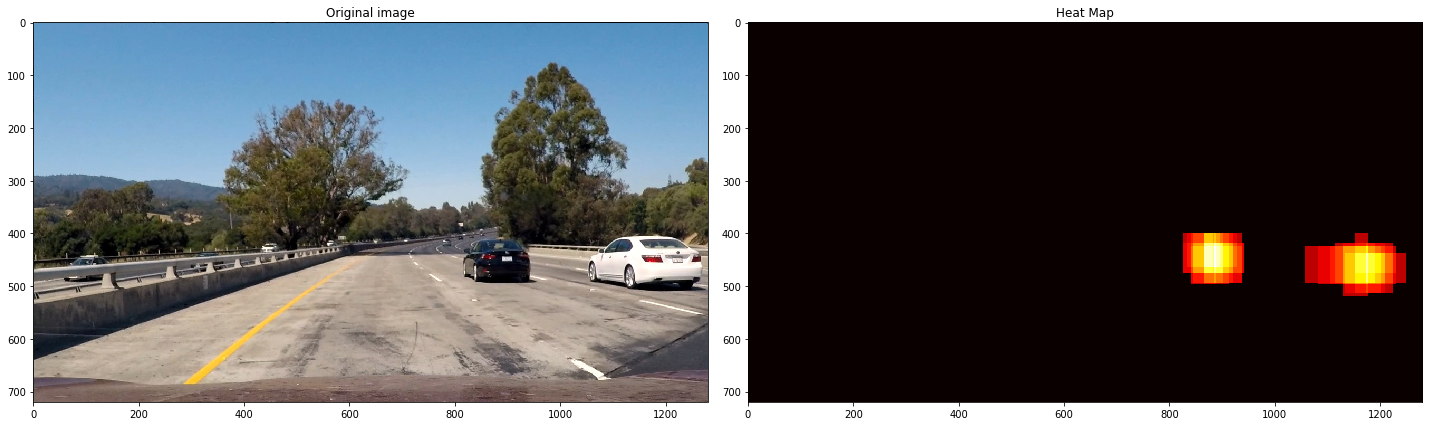

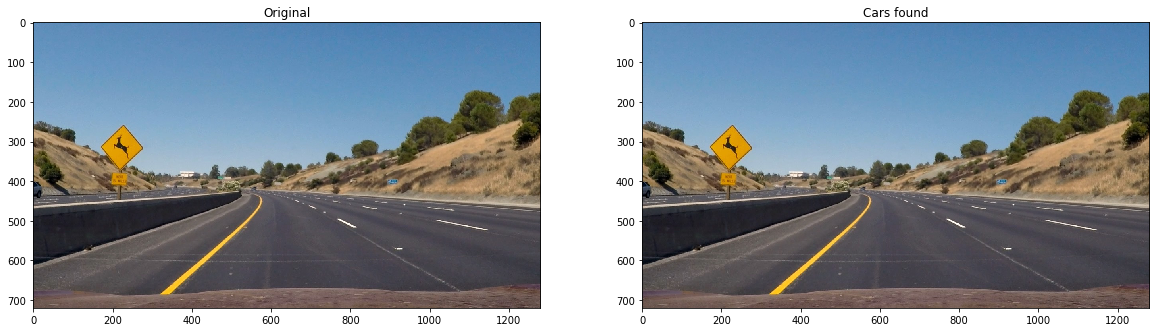

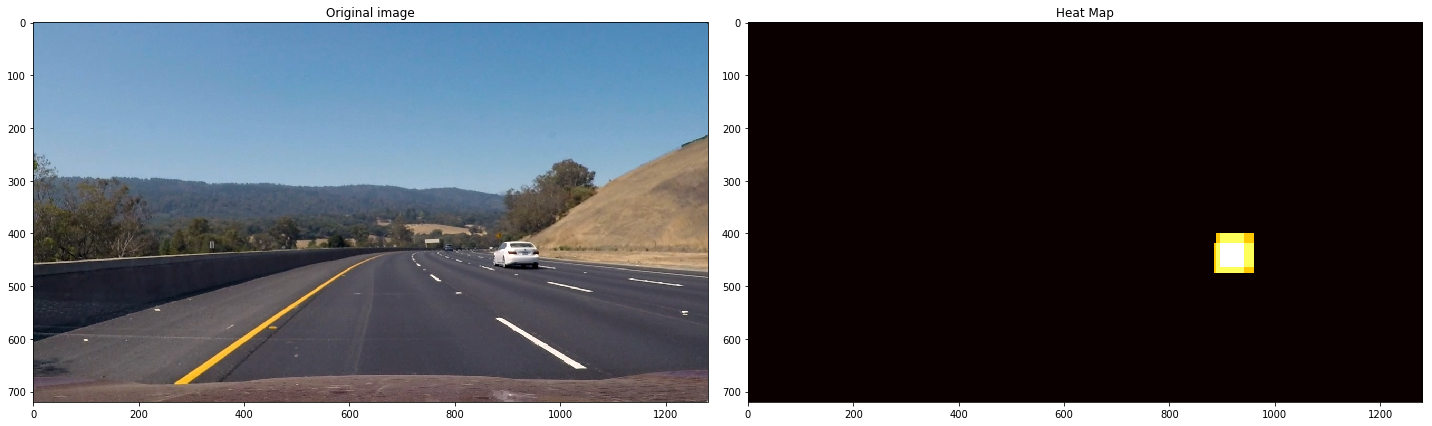

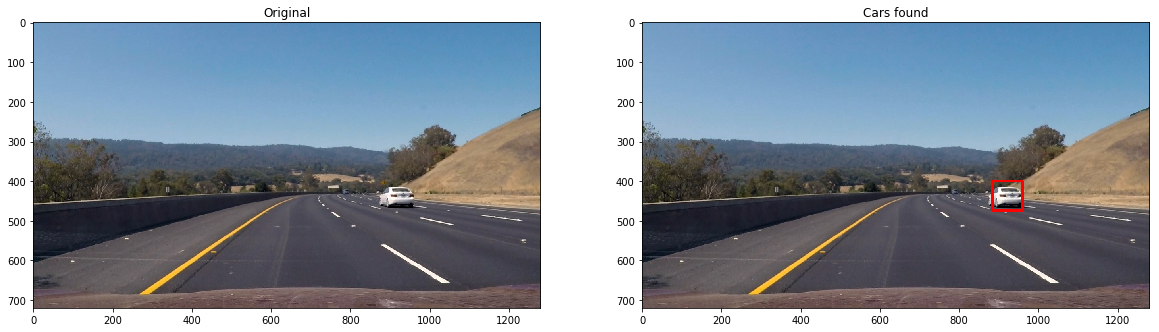

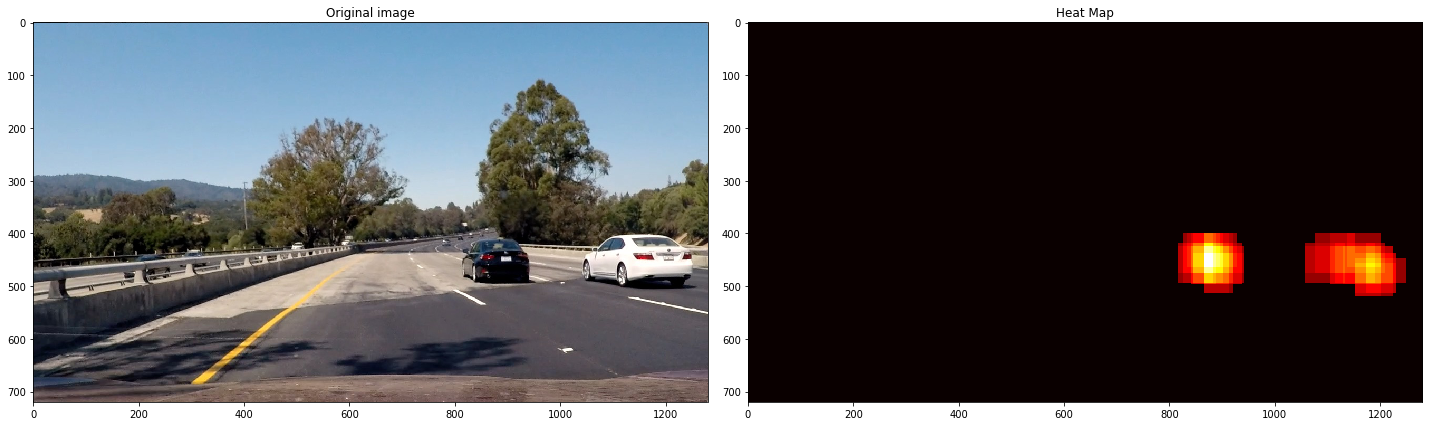

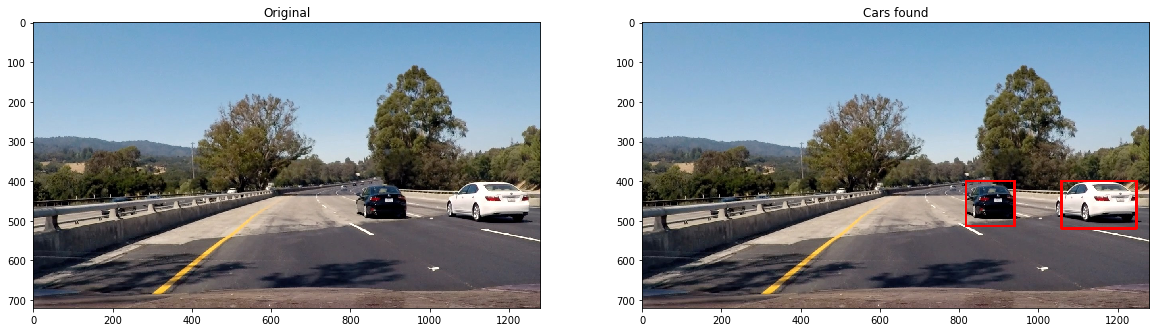

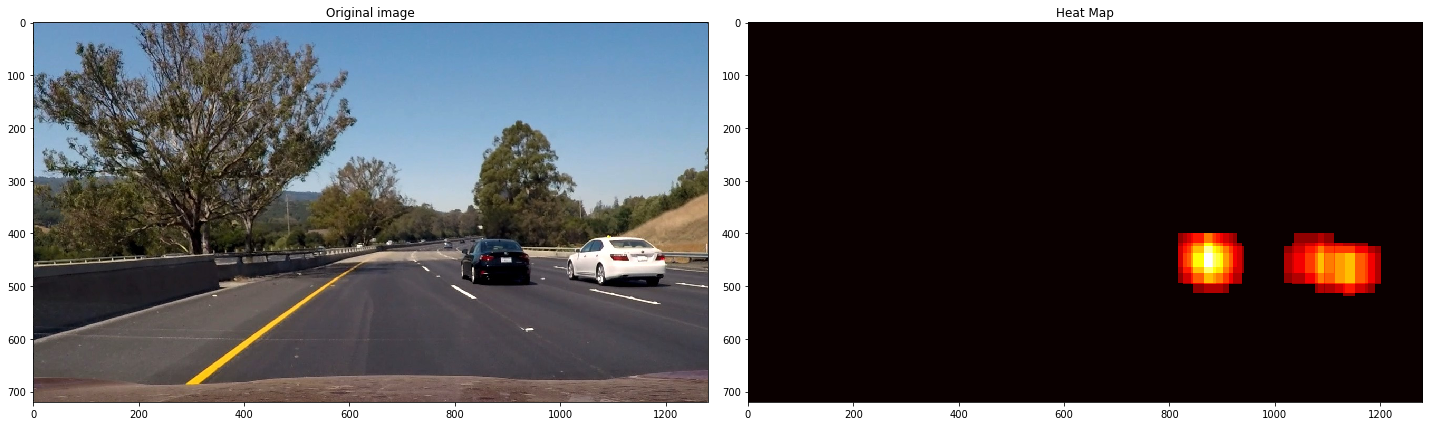

In [130]:
save_index = 1
for image_name in glob.glob('./test_images/test*.jpg'):
    draw_cars(image_name, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, visualize=False,
              save_index=save_index)
    save_index += 1


In [87]:
def plot_hogs(images, titles, save_name):
    fig, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(20, 10))
    a1.imshow(images[0])
    a1.set_title(titles[0], fontsize=12)
    a2.imshow(images[1] * 255, cmap='gray')
    a2.set_title(titles[1], fontsize=12)
    a3.imshow(images[2] * 255, cmap='gray')
    a3.set_title(titles[2], fontsize=12)
    a4.imshow(images[3] * 255, cmap='gray')
    a4.set_title(titles[3], fontsize=12)
    if save_name is not None:
        fig.savefig(save_name, bbox_inches='tight')

img = cv2.imread('./data/vehicles/GTI_Far/image0004.png')
new_box_list, hog_images = find_cars_boxes(img, [0, 64], 1.0, svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins, window=64, cells_per_step=2, 
                                    source_color_space='BGR', visualize=True)

plot_hogs([img, hog_images[0], hog_images[1], hog_images[2]], 
          ['Car image', 'HOG channel 1', 'HOG channel 2', 'HOG channel 3'], 
          './output_images/hog_car.jpg')

img = cv2.imread('./data/non-vehicles/GTI/image13.png')
new_box_list, hog_images = find_cars_boxes(img, [0, 64], 1.0, svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins, window=64, cells_per_step=2, 
                                    source_color_space='BGR', visualize=True)

plot_hogs([img, hog_images[0], hog_images[1], hog_images[2]], 
          ['Non-car image', 'HOG channel 1', 'HOG channel 2', 'HOG channel 3'], 
          './output_images/hog_notcar.jpg')



**Pipeline for videos**

In [45]:
heats = None

def find_cars_video(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, source_color_space='RGB', heats_count=5, heat_threshold=12):
    """
    Returns labels of found cars on the image from the video stream
    """
    
    y_start_stops = [[400, 480], [400, 580], [400, 625]]
    scales = [1.0, 1.2, 1.5]
    box_list = []
    for index in range(len(scales)):
        new_box_list = find_cars_boxes(img, y_start_stops[index], scales[index], svc, X_scaler, 
                                    orient, pix_per_cell, cell_per_block, 
                                    spatial_size, hist_bins, window=64, cells_per_step=2, 
                                    source_color_space=source_color_space)
        for box in new_box_list:
            box_list.append(box)

    box_list = np.asarray(box_list)
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, box_list)
    
    global heats
    
    if heats is not None and heats.shape[0] > heats_count:
        heats = np.delete(heats, 0, axis=0)
    
    if heats is None:    
        heats = np.stack([heat])
    else:
        heats = np.concatenate([heats, np.expand_dims(heat, axis=0)])
        
    avg_heat = np.sum(heats, axis=0)
    avg_heat = apply_threshold(avg_heat, heat_threshold)
   
    heatmap = np.clip(avg_heat, 0, 255)
    labels = label(heatmap)
    return labels

In [41]:
def process_video_image(image):
    """
    Finds labels for the image from the video stream and draws corresponding cars on it
    """
    labels = find_cars_video(image, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, 
                       source_color_space='RGB')
    draw_image = draw_labeled_bboxes(image, labels)
    return draw_image


In [42]:
def process_video(video_clip_name, output_clip_name):
    """
    Processes the video clip and produces output clip with lanes on it (model v2). 
    """
    global heats
    heats = None
    
    video_clip = VideoFileClip(video_clip_name)
    output_clip = video_clip.fl_image(process_video_image)
    %time output_clip.write_videofile(output_clip_name, audio=False)

In [131]:
process_video('./test_video.mp4', './output_videos/output_test_video.mp4')

[MoviePy] >>>> Building video ./output_videos/output_test_video.mp4
[MoviePy] Writing video ./output_videos/output_test_video.mp4


 97%|█████████▋| 38/39 [00:27<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_test_video.mp4 

CPU times: user 27.6 s, sys: 730 ms, total: 28.4 s
Wall time: 28.7 s


In [46]:
process_video('./project_video.mp4', './output_videos/output_project_video.mp4')

[MoviePy] >>>> Building video ./output_videos/output_project_video.mp4
[MoviePy] Writing video ./output_videos/output_project_video.mp4


100%|█████████▉| 1260/1261 [15:36<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_project_video.mp4 

CPU times: user 15min 27s, sys: 28.3 s, total: 15min 56s
Wall time: 15min 37s
